In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as pl
import scipy.optimize as so
#%%

In [2]:
f = lambda x: np.cos(.7*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()
#f = lambda x: np.tan(0.9*x).flatten()

def kernel(data1,data2,theta,wantderiv=True,measnoise=1.):
    # Uses exp(theta) to ensure positive hyperparams
    theta = np.squeeze(theta)
    theta = np.exp(theta)
    # Squared exponential
    if np.ndim(data1) == 1:
        d1 = np.shape(data1)[0]
        n = 1
        data1 = data1*np.ones((d1,1))
        data2 = data2*np.ones((np.shape(data2)[0],1))
    else:
        (d1,n) = np.shape(data1)

    d2 = np.shape(data2)[0]
    sumxy = np.zeros((d1,d2))
    for d in range(n):
        D1 = np.transpose([data1[:,d]]) * np.ones((d1,d2))
        D2 = [data2[:,d]] * np.ones((d1,d2))
        sumxy += (D1-D2)**2*theta[d+1]

    k = theta[0] * np.exp(-0.5*sumxy)
    #k = theta[0]**2 * np.exp(-sumxy/(2.0*theta[1]**2))

    #print k
    #print measnoise*theta[2]**2*np.eye(d1,d2)
    if wantderiv:
        K = np.zeros((d1,d2,len(theta)+1))
        # K[:,:,0] is the original covariance matrix
        K[:,:,0] = k + measnoise*theta[2]*np.eye(d1,d2)
        K[:,:,1] = k
        K[:,:,2] = -0.5*k*sumxy
        K[:,:,3] = theta[2]*np.eye(d1,d2)
        return K
    else:
        return k + measnoise*theta[2]*np.eye(d1,d2)
    
def logPosterior(theta,*args):
    data,t = args
    k = kernel(data,data,theta,wantderiv=False)
    L = np.linalg.cholesky(k)
    beta = np.linalg.solve(L.transpose(), np.linalg.solve(L,t))
    logp = -0.5*np.dot(t.transpose(),beta) - np.sum(np.log(np.diag(L))) - np.shape(data)[0] /2. * np.log(2*np.pi)
    return -logp

def gradLogPosterior(theta,*args):
    #print(args)
    data,t = args
    theta = np.squeeze(theta)
    d = len(theta)
    K = kernel(data,data,theta,wantderiv=True)

    L = np.linalg.cholesky(np.squeeze(K[:,:,0]))
    invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(data)[0])))
    dlogpdtheta = np.zeros(d)
    for d in range(1,len(theta)+1):
        dlogpdtheta[d-1] = 0.5*np.dot(t.transpose(), np.dot(invk, np.dot(np.squeeze(K[:,:,d]), np.dot(invk,t)))) - 0.5*np.trace(np.dot(invk,np.squeeze(K[:,:,d])))

    return -dlogpdtheta

In [3]:
N = 10         # numero punti training
n = 500        # numeroy punti test
s = 0.05       # noise variance

rng = np.random.RandomState(2)
x = rng.uniform(-5, 5, size=(N,1))
xstar = np.linspace(-5, 5, n).reshape(-1,1)
t = f(x) + s*np.random.randn(N)
t = t.reshape(N,1)

In [4]:
lengthscale = 1
constantscale = 1
noise_scale = 1
theta = np.array([constantscale,lengthscale,  noise_scale])

In [5]:
theta = so.fmin_cg(logPosterior, theta, fprime=gradLogPosterior, args=(x,t), gtol=1e-4,maxiter=100,disp=1)

Optimization terminated successfully.
         Current function value: -5.127152
         Iterations: 12
         Function evaluations: 23
         Gradient evaluations: 23


In [6]:
k = kernel(x,x,theta,wantderiv=False)
kstar = kernel(xstar,x, theta, wantderiv=False, measnoise=False)
kstarstar = kernel(xstar,xstar,theta,wantderiv=False)
kstarstar_diag = np.diag(kstarstar)

In [7]:
L = np.linalg.cholesky(k)
invk = np.linalg.solve(L.transpose(),np.linalg.solve(L,np.eye(np.shape(x)[0])))
mean = np.squeeze(np.dot(kstar,np.dot(invk,t)))
var = kstarstar_diag - np.diag(np.dot(kstar,np.dot(invk,kstar.T)))
var = np.squeeze(np.reshape(var,(n,1)))
s = np.sqrt(var)

[-5, 5, -3, 3]

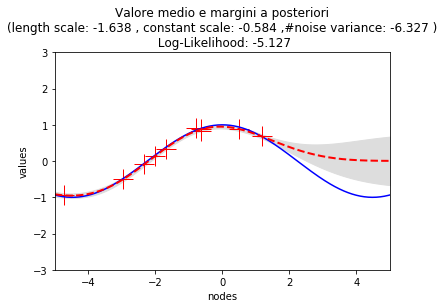

In [8]:
pl.figure()
pl.clf()
pl.plot(x, t, 'r+', ms=20)
pl.plot(xstar, f(xstar), 'b-')
pl.gca().fill_between(xstar.flat, mean-s, mean+s, color="#dddddd")
pl.plot(xstar, mean, 'r--', lw=2)
pl.title('Valore medio e margini di confidenza')
loglikelihood = logPosterior(theta, x,t)
pl.title('Valore medio e margini a posteriori\n(length scale: %.3f , constant scale: %.3f ,\
#noise variance: %.3f )\n Log-Likelihood: %.3f'
        % (theta[1], theta[0], theta[2], loglikelihood))
pl.xlabel('nodes')
pl.ylabel('values')
pl.savefig('predict.png', bbox_inches='tight')
pl.axis([-5, 5, -3, 3])

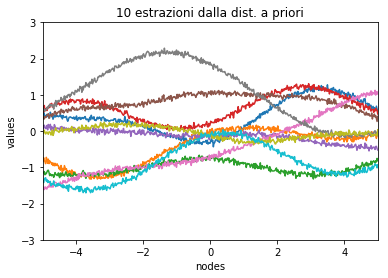

In [9]:
L2 = np.linalg.cholesky(kstarstar + 1e-6*np.eye(n))
f_prior = np.dot(L2, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(xstar, f_prior)
pl.title('10 estrazioni dalla dist. a priori')
pl.xlabel('nodes')
pl.ylabel('values')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')

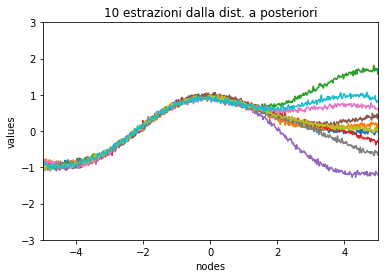

In [10]:
Lk = np.linalg.solve(L, kstar.T)
L2 = np.linalg.cholesky(kstarstar+ 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mean.reshape(-1,1) + np.dot(L2, np.random.normal(size=(n,10)))
pl.figure(3)
pl.clf()
pl.plot(xstar, f_post)
pl.title('10 estrazioni dalla dist. a posteriori')
pl.xlabel('nodes')
pl.ylabel('values')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')